In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
# from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
from pytictoc import TicToc

In [2]:
ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_log_trans_random_extra_vars_TCW-T-CAPE-CIN_broadfield_channel_padded_10_first_days_5.pkl", "rb"))

sampler_test = torch.utils.data.SequentialSampler(ds_test)

dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=128, sampler=sampler_test
)

In [3]:
gan = BaseGAN.load_from_checkpoint("/home/jupyter/data/saved_models/leingan/ens10_temperature/0/epoch=149-step=100499.ckpt")

gen = gan.gen
gen = gen.to(device)
gen.train(False);

In [123]:

from multiprocessing import Pool

t = TicToc()
nens = 30
ds_min, ds_max, tp_log = ds_test.mins.tp.values, ds_test.maxs.tp.values, ds_test.tp_log
crps = []
max_pool_crps = []
avg_pool_crps = []
rmse = []
rhist = xr.DataArray(data = np.zeros(31), dims = "rank")
rels = []
for batch_idx, (x,y) in enumerate(dl_test):
    if batch_idx<1:
        x = x.to(device)
        preds = []
        t.tic()
        for i in range(nens):
            noise = torch.randn(x.shape[0], 1, x.shape[2], x.shape[3]).to(device)
    #             t.tic()
            pred = gen(x, noise).detach().to('cpu').numpy().squeeze()
    #             t.toc('single batch single prediction took')
            preds.append(pred)
        t.toc('model passes took', restart=True)
        preds = np.array(preds)
        truth = y.numpy().squeeze(1)
        truth = xr.DataArray(
                truth,
                dims=['sample','lat', 'lon'],
                name='tp'
            )
        preds = xr.DataArray(
                preds,
                dims=['member', 'sample', 'lat', 'lon'],
                name='tp'
            )
        t.toc('conversion to xarray took', restart=True)

        truth = truth * (ds_max - ds_min) + ds_min

        preds = preds * (ds_max - ds_min) + ds_min

        if tp_log:
            truth = log_retrans(truth, tp_log)
            preds = log_retrans(preds, tp_log)

        truth_pert = truth + np.random.normal(scale=1e-6, size=truth.shape)
        preds_pert = preds + np.random.normal(scale=1e-6, size=preds.shape)

        t.tic()
        for sample in range(x.shape[0]):
            t.tic()
            sample_crps = xs.crps_ensemble(truth.sel(sample=sample), preds.sel(sample=sample)).values
            truth_course = truth.coarsen(lat=4, lon=4)
            preds_course = preds.coarsen(lat=4, lon=4)
            sample_max_pool_crps = xs.crps_ensemble(truth_course.max().sel(sample=sample), preds_course.max().sel(sample=sample)).values
            sample_avg_pool_crps = xs.crps_ensemble(truth_course.mean().sel(sample=sample), preds_course.mean().sel(sample=sample)).values
            crps.append(sample_crps)
            max_pool_crps.append(sample_max_pool_crps)
            avg_pool_crps.append(sample_avg_pool_crps)
            
            t.toc('crps took', restart=True)
            
            sample_rmse = xs.rmse(preds.sel(sample=sample).mean('member'), truth.sel(sample=sample), dim=['lat', 'lon']).values
            rmse.append(sample_rmse)
            
            t.tic()
            rhist += xs.rank_histogram(truth_pert.sel(sample=sample), preds_pert.sel(sample=sample)).values
            t.toc('rank histogram took', restart=True)
            
            t.tic()
            rel = xs.reliability(truth.sel(sample=sample)>0.1,(preds.sel(sample=sample)>0.1).mean('member'), probability_bin_edges=np.array([0.1*i for i in range(10)]))
            rel = xr.where(np.isnan(rel), 0, rel)
            rel['relative_freq'] = rel
            rels.append(rel)
            t.toc('reliability took', restart=True)
            
        t.toc('metrics took', restart=True)
         
        
rels = xr.concat(rels, dim = "patch")
weights = rels.samples / rels.samples.sum(dim="patch")
weighted_relative_freq = (weights*rels.relative_freq).sum(dim="patch")
samples = rels.samples.sum(dim="patch")


model passes took 7.311347 seconds.
conversion to xarray took 0.074660 seconds.
crps took 1.607146 seconds.
rank histogram took 0.021346 seconds.
reliability took 0.007421 seconds.
crps took 1.604980 seconds.
rank histogram took 0.018729 seconds.
reliability took 0.006861 seconds.
crps took 1.608524 seconds.
rank histogram took 0.020672 seconds.
reliability took 0.007360 seconds.
crps took 1.583876 seconds.
rank histogram took 0.019826 seconds.
reliability took 0.006954 seconds.
crps took 1.602211 seconds.
rank histogram took 0.019059 seconds.
reliability took 0.006946 seconds.
crps took 1.593195 seconds.
rank histogram took 0.021298 seconds.
reliability took 0.007012 seconds.
crps took 1.569894 seconds.
rank histogram took 0.020896 seconds.
reliability took 0.006926 seconds.
crps took 1.623248 seconds.
rank histogram took 0.021639 seconds.
reliability took 0.007330 seconds.
crps took 1.601426 seconds.
rank histogram took 0.019947 seconds.
reliability took 0.007244 seconds.
crps took 1

KeyboardInterrupt: 

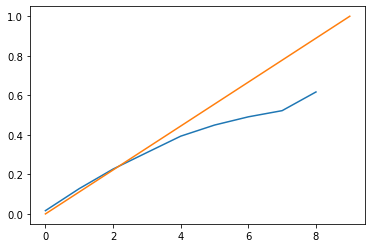

In [122]:
plt.plot(weighted_relative_freq)
plt.plot(np.linspace(0,1,10))

In [97]:
weighted_relative_freq

<xarray.DataArray (forecast_probability: 9)>
array([0.01802034, 0.11740943, 0.23449816, 0.31292786, 0.3722183 ,
       0.44965386, 0.51072902, 0.54630481, 0.62481173])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85

In [ ]:
weighted = torch.sum

In [88]:
weighted = temp.samples * temp.relative_freq

In [89]:
weighted.sum(dim = "patch")

<xarray.DataArray (forecast_probability: 9)>
array([19165., 24202., 35091., 19418., 32087., 47101., 34648., 24456.,
       59951.])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85

In [56]:
rels[0]

<xarray.DataArray 'tp' (forecast_probability: 9)>
array([0.7288865 , 0.49126638, 0.72767204, 0.775     , 0.77138158,
       0.69156884, 0.67514451, 0.6913767 , 0.77017008])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85
    samples               (forecast_probability) float64 1.859e+03 ... 2.293e+03
    new                   (forecast_probability) float64 0.7289 ... 0.7702

In [7]:
rhist

<xarray.DataArray (rank: 31)>
array([3616926., 2987431., 2733386., 2579554., 2474460., 2395274.,
       2329544., 2272505., 2223361., 2183005., 2142712., 2109671.,
       2076850., 2041014., 2012017., 1980913., 1953110., 1928052.,
       1901805., 1879979., 1851861., 1826127., 1799001., 1771020.,
       1741986., 1707320., 1667349., 1622778., 1578528., 1558052.,
       1935049.])
Dimensions without coordinates: rank

In [43]:
rhist

<xarray.DataArray 'histogram_rank' (rank: 31)>
array([529, 543, 562, 535, 537, 536, 549, 548, 574, 519, 544, 557, 559,
       515, 566, 512, 525, 551, 524, 529, 549, 476, 539, 558, 528, 556,
       555, 531, 482, 470, 326])
Coordinates:
  * rank     (rank) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 27.0 28.0 29.0 30.0 31.0

<xarray.DataArray 'tp' (patch: 128, forecast_probability: 9)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85
    samples               (patch, forecast_probability) float64 1.869e+03 ......
Dimensions without coordinates: patch

In [42]:
rels[1].forecast_probability

<xarray.DataArray 'forecast_probability' (forecast_probability: 9)>
array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85
    samples               (forecast_probability) float64 1.012e+03 ... 2.105e+03

In [45]:
rels[0].samples

<xarray.DataArray 'samples' (forecast_probability: 9)>
array([1813.,  556.,  834.,  370.,  702.,  787.,  822.,  814., 2216.])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85
    samples               (forecast_probability) float64 1.813e+03 ... 2.216e+03

In [34]:
rels[0].forecast_probability * rels[0].samples

<xarray.DataArray (forecast_probability: 9)>
array([  93.45,   85.5 ,  214.  ,  140.  ,  264.6 ,  467.5 ,  486.2 ,
        540.  , 2108.  ])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85
    samples               (forecast_probability) float64 1.869e+03 ... 2.48e+03

<xarray.DataArray 'tp' (patch: 128, forecast_probability: 9)>
array([[0.74351903, 0.61510791, 0.72541966, ..., 0.72384428, 0.66461916,
        0.73104693],
       [0.14031621, 0.21223022, 0.23769731, ..., 0.34991274, 0.45849802,
        0.53396675],
       [0.44897959, 0.7493188 , 0.69238006, ..., 0.4669749 , 0.44303797,
        0.46684564],
       ...,
       [0.        , 0.        ,        nan, ...,        nan,        nan,
               nan],
       [0.        , 0.        ,        nan, ...,        nan,        nan,
               nan],
       [0.        , 0.        ,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85
    samples               (patch, forecast_probability) float64 1.813e+03 ......
Dimensions without coordinates: patch

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
# from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
from pytictoc import TicToc

In [2]:
ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_log_trans_random_extra_vars_TCW-T-CAPE-CIN_broadfield_channel_padded_10_first_days_5.pkl", "rb"))

sampler_test = torch.utils.data.SequentialSampler(ds_test)

dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=128, sampler=sampler_test
)

In [3]:
def plot_samples_per_input(data, gen, samples, device):
    fig, axs = plt.subplots(len(data), samples+2, figsize=(5*samples, len(data)*samples))
    gen_images = np.zeros((len(data),samples,16,16))
    for i, d in enumerate(data):
        for s in range(samples):
            cond = torch.tensor(d[0]).unsqueeze(0).to(device)
            pred = gen(cond).detach().cpu().numpy()
            gen_images[i, s, :, :] = pred[0,0,:,:]
    
    for i, d in enumerate(data):
        cond = torch.tensor(d[0]).unsqueeze(0).to(device)
        lr = cond[0,0,:,:].detach().cpu().numpy()
        if lr.shape[0]==64:
            lr = lr[24:40, 24:40]
        hr = model.downsample(torch.tensor(d[1][0:1,:,:]), scale_factor = 0.125, mode = 'bilinear', align_corners = False).detach().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[i,:,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[i,:,:,:])])
        im = axs[i,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[i,0])
        im = axs[i,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for j in range(samples):
            im = axs[i,j+2].imshow(gen_images[i,j,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
#     plt.show()  
    cols = ["Forecast", "Ground Truth"] + [f"Prediction {i+1}" for i in range(samples)]
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
    plt.tight_layout()
    plt.show


In [17]:
model = CheckCorrector.load_from_checkpoint(
    '/home/jupyter/data/saved_models/corrector/ensemble_forecast_x10_log_trans_random_extra_vars_TCW-T-CAPE-CIN_broadfield_channel_padded_10/11/epoch=159-step=82719.ckpt')



In [18]:
# sample_indices = np.random.choice(100, size = 40, replace=False)
# ds_test = torch.utils.data.Subset(ds_test, sample_indices)

In [19]:
device = 'cpu'

/opt/conda/envs/ilan/lib/python3.9/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


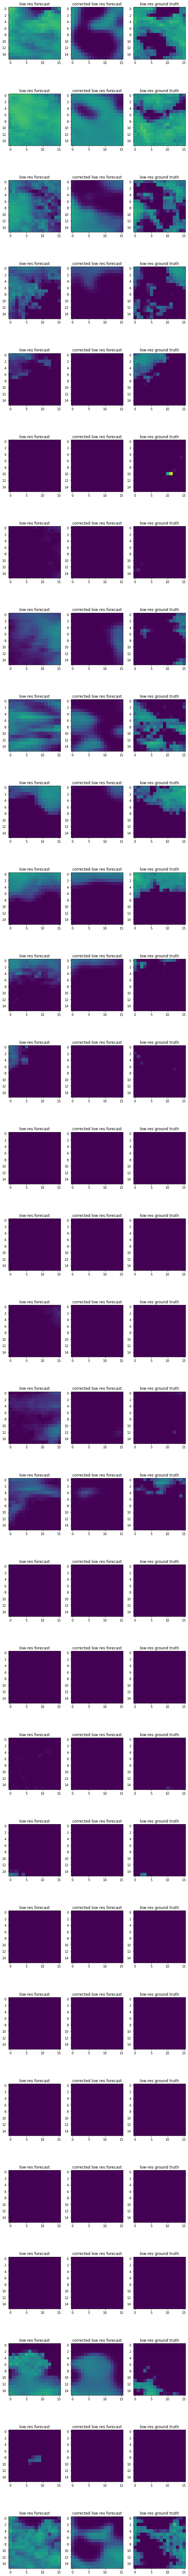

In [20]:
k = 30
fig, axs = plt.subplots(k, 3, figsize = (10, 5*k))
for i in range(k):
    axs[i,0].imshow(ds_test[i][0][0,:,:], vmin = 0, vmax = 1)
    axs[i,0].set_title('low-res forecast')
    img = model.corrector(torch.tensor(ds_test[i][0]).unsqueeze(0)).squeeze().detach().numpy()
    axs[i,1].imshow(img, vmin = 0, vmax = 1)
    axs[i,1].set_title('corrected low res forecast')
    img2 = model.downsample(torch.tensor(ds_test[i][1]).unsqueeze(0), scale_factor = 0.125, mode = 'bilinear', align_corners = False).squeeze().detach().numpy()
    axs[i,2].imshow(img2, vmin = 0, vmax = 1)
    axs[i,2].set_title('low-res ground truth')
# plt.figure()
# plt.imshow(ds_test[i][1].squeeze())



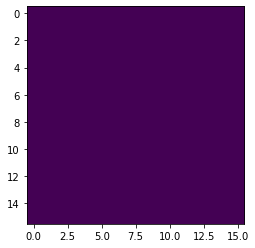

In [10]:
plt.imshow(img2)

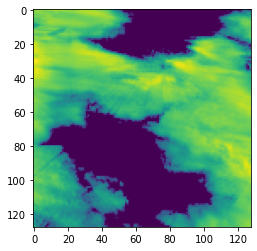

In [11]:
plt.imshow(ds_test[0][1].squeeze())

In [12]:
a=torch.tensor(ds_test[i][0]).unsqueeze(0)

In [19]:
torch.linalg.norm(a.view(-1), 1)

tensor(380.6600)

In [18]:
a.view(-1)

tensor([0., 0., 0.,  ..., 0., 0., 0.])